In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import zipfile
import os

# Unzip train and test data
with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip", "r") as zip_ref:
    zip_ref.extractall("/kaggle/working/train")

with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip", "r") as zip_ref:
    zip_ref.extractall("/kaggle/working/test")

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# ================================
# STEP 1: Imports and Setup
# ================================
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

# ================================
# STEP 2: Paths and Preprocessing
# ================================
train_dir = "/kaggle/working/train/train"
test_dir = "/kaggle/working/test/test"
IMG_SIZE = 299
BATCH_SIZE = 32

# Labels from filenames
filenames = os.listdir(train_dir)
labels = ['dog' if 'dog' in fname else 'cat' for fname in filenames]
df = pd.DataFrame({'filename': filenames, 'class': labels})

# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=42)

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
# ================================
# STEP 3: Image Generators
# ================================
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df, train_dir, x_col='filename', y_col='class',
                                           target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)

val_data = val_gen.flow_from_dataframe(val_df, train_dir, x_col='filename', y_col='class',
                                       target_size=(IMG_SIZE, IMG_SIZE), class_mode='binary', batch_size=BATCH_SIZE)

test_df = pd.DataFrame({'filename': os.listdir(test_dir)})
test_data = test_gen.flow_from_dataframe(test_df, test_dir, x_col='filename', class_mode=None,
                                         target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)

# =========================
# STEP 4: Build Heavy Xception Model (More Parameters)
# =========================
from tensorflow.keras.regularizers import l2

base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Unfreeze entire base from the beginning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),  # instantiate the loss
    metrics=['accuracy']
)

# =========================
# STEP 4: Training the Heavier Model (5 Epochs)
# =========================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]

model.fit(train_data, validation_data=val_data, epochs=5, callbacks=callbacks, verbose=1)


2025-04-22 22:58:09.902303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745362690.084258      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745362690.141322      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


I0000 00:00:1745362702.244324      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745362723.195235      96 service.cc:148] XLA service 0x7f9f34002d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745362723.196111      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745362724.238824      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/704 ━━━━━━━━━━━━━━━━━━━━ 3:58:58 20s/step - accuracy: 0.5312 - loss: 0.7138

I0000 00:00:1745362732.156910      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


704/704 ━━━━━━━━━━━━━━━━━━━━ 448s 608ms/step - accuracy: 0.9781 - loss: 0.0980 - val_accuracy: 0.9940 - val_loss: 0.0214
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 424s 596ms/step - accuracy: 0.9905 - loss: 0.0287 - val_accuracy: 0.9936 - val_loss: 0.0301
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 421s 592ms/step - accuracy: 0.9912 - loss: 0.0275 - val_accuracy: 0.9952 - val_loss: 0.0205
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 423s 595ms/step - accuracy: 0.9926 - loss: 0.0222 - val_accuracy: 0.9952 - val_loss: 0.0202
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 425s 598ms/step - accuracy: 0.9901 - loss: 0.0278 - val_accuracy: 0.9948 - val_loss: 0.0198


In [4]:
# Save final model
model.save("/kaggle/working/xception_model_1.h5")

**Results** before fine tuning: **Score: 0.34815**

In [6]:
from tensorflow.keras.models import load_model


model_path = "/kaggle/working/xception_model_1.h5"
model = load_model(model_path)
print(f"✅ Loaded model from: {model_path}")

✅ Loaded model from: /kaggle/working/xception_model_1.h5


In [8]:
pred_probs = model.predict(test_data, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

test_df['id'] = test_df['filename'].apply(lambda x: int(x.split('.')[0]))
submission = pd.DataFrame({'id': test_df['id'], 'label': pred_labels})
submission = submission.sort_values('id')

submission.to_csv("/kaggle/working/submission.csv", index=False)
print("✅ Submission saved as submission.csv")

390/391 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

E0000 00:00:1745365165.508676      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745365165.747472      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745365166.319070      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745365166.581817      94 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


391/391 ━━━━━━━━━━━━━━━━━━━━ 52s 133ms/step
✅ Submission saved as submission.csv


In [11]:
# =========================
# STEP 5: Fine-Tune Top Layers
# =========================
# Unfreeze top layers for fine-tuning
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss=BinaryCrossentropy(), metrics=['accuracy'])

model.fit(train_data, validation_data=val_data, epochs=5, callbacks=callbacks, verbose=1)

# Save final model
model.save("/kaggle/working/xception_model_FT.h5")


Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 428s 590ms/step - accuracy: 0.9923 - loss: 0.0197 - val_accuracy: 0.9952 - val_loss: 0.0199
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 411s 579ms/step - accuracy: 0.9933 - loss: 0.0209 - val_accuracy: 0.9952 - val_loss: 0.0194


In [12]:
# =========================
# STEP 6: Prediction & Submission
# =========================
pred_probs = model.predict(test_data, verbose=1)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

test_df['id'] = test_df['filename'].apply(lambda x: int(x.split('.')[0]))
submission = pd.DataFrame({'id': test_df['id'], 'label': pred_labels})
submission = submission.sort_values('id')

submission.to_csv('/kaggle/working/submission.csv', index=False)
print("✅ Submission saved as submission.csv")



391/391 ━━━━━━━━━━━━━━━━━━━━ 49s 118ms/step
✅ Submission saved as submission.csv


**Results** on prediction after fne tuning: 0.34

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step


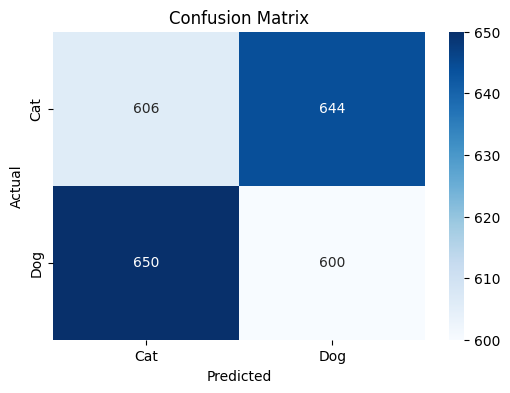


Classification Report:
              precision    recall  f1-score   support

         Cat       0.48      0.48      0.48      1250
         Dog       0.48      0.48      0.48      1250

    accuracy                           0.48      2500
   macro avg       0.48      0.48      0.48      2500
weighted avg       0.48      0.48      0.48      2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


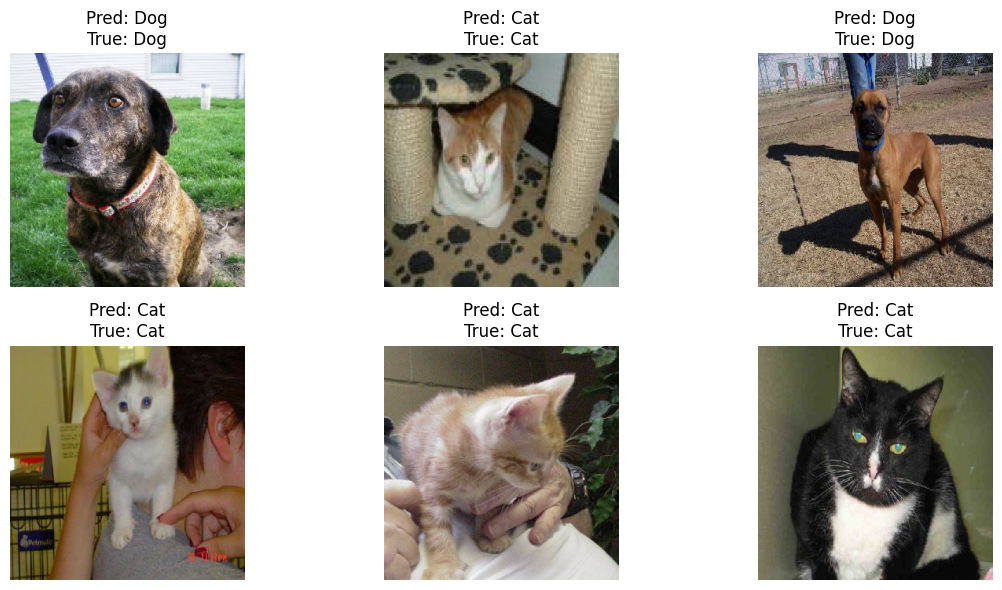

In [13]:
# ===============================
# STEP 5: Evaluate Model Performance
# ===============================

# 1. Plot training history (if you saved it)
# Unfortunately, this won't work unless you saved the history object when calling model.fit.
# If not, you can skip to metrics/visuals below.

# 2. Confusion Matrix on Validation Set
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
val_data.reset()
val_preds = (model.predict(val_data) > 0.5).astype(int).ravel()
true_labels = val_data.classes

# Confusion matrix
cm = confusion_matrix(true_labels, val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, val_preds, target_names=['Cat', 'Dog']))

# 4. Visualize Predictions on Validation Set
val_data.reset()
sample_images, sample_labels = next(val_data)
sample_preds = (model.predict(sample_images) > 0.5).astype(int).ravel()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    pred_class = "Dog" if sample_preds[i] == 1 else "Cat"
    true_class = "Dog" if sample_labels[i] == 1 else "Cat"
    plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
    plt.axis('off')
plt.tight_layout()
plt.show()


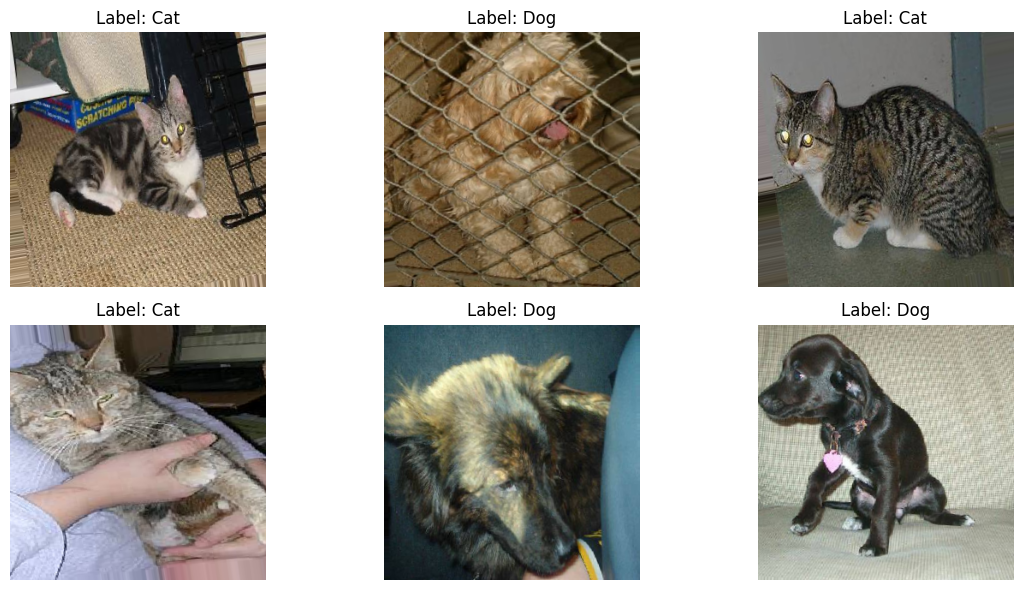

In [14]:
import matplotlib.pyplot as plt

sample_batch = next(train_data)
images, labels = sample_batch

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {'Dog' if labels[i]==1 else 'Cat'}")
    plt.axis('off')
plt.tight_layout()
plt.show()
